<a id="intro_dataset"></a>
<h2 style="font-family: 'Georgia'; color: #34495e; border-bottom: 3px solid #3498db; padding-bottom: 10px;">Exploring the dataset</h2>

In [2]:
# all necessary libraries imported here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping

In [3]:
# Load the data
df = pd.read_csv('/kaggle/input/soil-moisture-remote-sensing-data-germany-2013/updated_data.csv')

# Data overview
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Descriptive statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())

Dataset Shape: (321584, 8)

First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_content  silt_content  \
0  2013-01-03    54.875      9.125           5.0          86.0           9.0   
1  2013-01-05    54.875      9.125           5.0          86.0           9.0   
2  2013-01-07    54.875      9.125           5.0          86.0           9.0   
3  2013-01-08    54.875      9.125           5.0          86.0           9.0   
4  2013-01-09    54.875      9.125           5.0          86.0           9.0   

     sm_aux  sm_tgt  
0  0.454120    0.53  
1  0.437102    0.44  
2  0.412978    0.42  
3  0.378734    0.55  
4  0.350740    0.46  

Missing values in each column:
time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

Descriptive statistics of the dataset:
            latitude      longitude  clay_content   sand_content  \
count  321584.000000  321584.0000

In [4]:
# Determine unique latitude-longitude pairs
unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(f"There are {unique_locations.shape[0]} unique locations in the dataset.")


There are 1166 unique locations in the dataset.


In [6]:
# Create a base map centered around Germany
loc = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap", width=800, height=800)

# Add unique locations to the map
for idx, row in unique_locations.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(loc)

# Display the map directly

In [7]:
# Create a unique identifier for each location
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()
# Determine the start and end of the time series
start_date = df['time'].min()
end_date = df['time'].max()
print(f"The time series starts on {start_date} and ends on {end_date}.")

The time series starts on 2013-01-01 and ends on 2013-12-31.


<a id="eda"></a>
<h2 style="font-family: 'Georgia'; color: #34495e; padding-bottom: 10px;">Exploratory Data Analysis</h2>

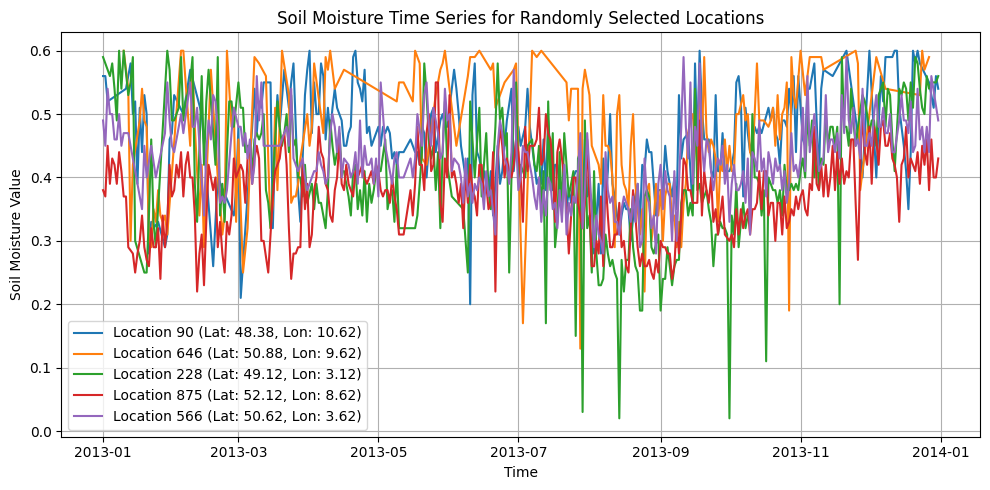

In [8]:
# Randomly select five unique location IDs
random_locations = np.random.choice(df['location_id'].unique(), 5, replace=False)

# Plot time series data for the selected locations
plt.figure(figsize=(10, 5))
for location in random_locations:
    subset = df[df['location_id'] == location]
    lat = subset['latitude'].iloc[0]
    lon = subset['longitude'].iloc[0]
    plt.plot(pd.to_datetime(subset['time']), subset['sm_tgt'], label=f"Location {location} (Lat: {lat:.2f}, Lon: {lon:.2f})")

plt.title("Soil Moisture Time Series for Randomly Selected Locations")
plt.xlabel("Time")
plt.ylabel("Soil Moisture Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

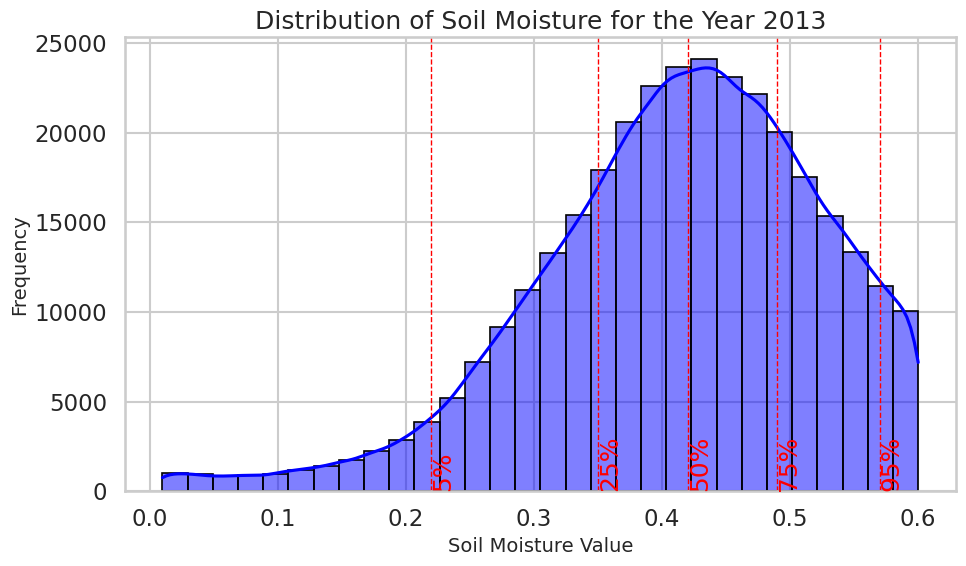

In [9]:
# Set style and context to make the plot look fancy
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['sm_tgt'], kde=True, bins=30, color='blue', edgecolor='black', linewidth=1.2)

# Mark percentiles on the plot
percentiles = [5, 25, 50, 75, 95]
for percentile in percentiles:
    value = np.percentile(df['sm_tgt'], percentile)
    plt.axvline(value, color='red', linestyle='dashed', linewidth=1)
    plt.text(value, 5, f'{percentile}%', color='red', rotation=90, verticalalignment='bottom')

# Set the title and labels
plt.title("Distribution of Soil Moisture for the Year 2013", fontsize=18)
plt.xlabel("Soil Moisture Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

<div style="padding: 15px; background-color:#ffffff ; font-family: 'Georgia';">
    <h3 style="color: #e74c3c; padding-bottom: 10px;">What we see in Histogram</h3>
    <ul style="color: #34495e; font-size: 16px;">
        <li>Less than <strong style="color: #e74c3c;">5%</strong> of soil moisture values indicate very dry conditions.</li>
        <li>Below <strong style="color: #e74c3c;">20%</strong> of the data points show soil moisture values that can be categorized as somewhat low, with a threshold of <strong>0.25</strong> differentiating between sufficiently irrigated and not sufficiently irrigated regions.</li>
        <li>A significant proportion, more than <strong style="color: #e74c3c;">50%</strong>, of the land has soil moisture values below <strong>40%</strong>, highlighting potential areas of concern.</li>
    </ul>
    <p style="color: #34495e; font-size: 16px; text-align: center;"><em>These observations shed light on the distribution and potential challenges related to soil moisture in the studied regions for the year 2013.</em></p>
</div>


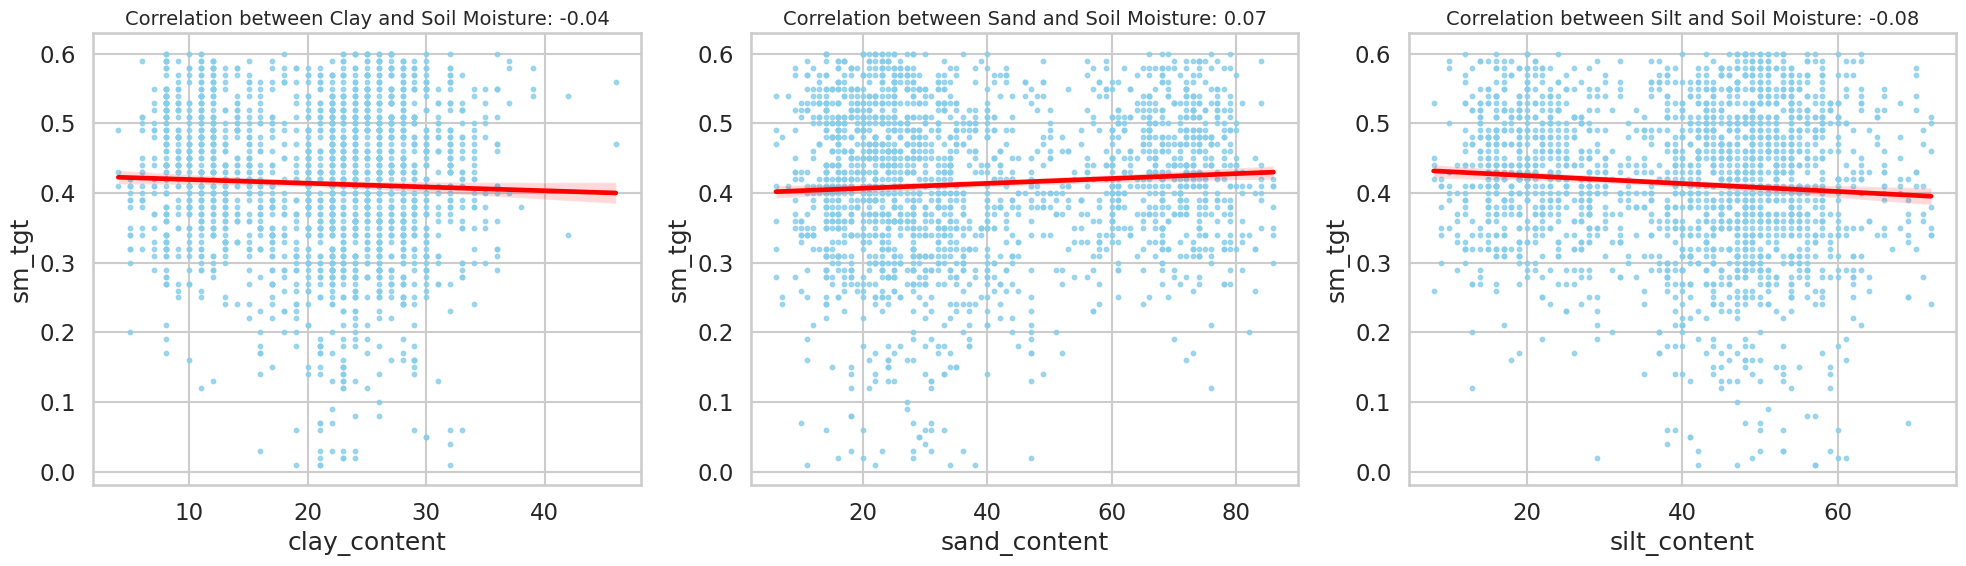

In [12]:
# Randomly sample 2000 data points from the dataframe
Sample_df = df.sample(n=2000, random_state=42)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
sns.set_context("talk")

# Initialize a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# List of soil components
components = ['clay_content', 'sand_content', 'silt_content']

# Plot scatter plots for each component
for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_tgt', data=Sample_df, ax=axes[i], color='skyblue', scatter_kws={'s':10}, line_kws={'color':'red'})
    
    # Calculate correlation and annotate the plot with its value
    correlation = Sample_df[component].corr(Sample_df['sm_tgt'])
    axes[i].set_title(f"Correlation between {component.split('_')[0].capitalize()} and Soil Moisture: {correlation:.2f}", fontsize=14)

# Adjust layout for better display
plt.tight_layout()
plt.show()

<div style=" background-color: #ffffff; padding: 15px; border-radius: 8px; background-color: #f9f9f9; font-family: 'Georgia';">
    <h3 style="color: #e67e22; border-bottom: 1px solid #2ecc71; padding-bottom: 10px;">Soil Composition vs. Soil Moisture: Observations</h3>
    <ul style="color: #34495e; font-size: 16px;">
        <li>The correlation plots do not indicate any <strong style="color: #e74c3c;">strong relationships</strong> between soil composition and soil moisture.</li>
        <li>There are very weak trends (red lines) observed (not to be considered seriously):
            <ul>
                <li>Higher clay content is associated with <strong style="color: #3498db;">lower soil moisture</strong>.</li>
                <li>Higher sand content seems to correspond with <strong style="color: #3498db;">greater soil moisture</strong>.</li>
                <li>Increased silt content is related to <strong style="color: #3498db;">reduced soil moisture</strong>.</li>
            </ul>
        </li>
        <li>The data appears scattered without a clear directional trend, suggesting that soil moisture may not be predominantly influenced by soil type alone.</li>
        <li>Given the dataset's origin from Europe, where many agricultural areas benefit from <strong style="color: #3498db;">automated irrigation systems</strong>, the lack of a clear trend may hint at the impact of artificial irrigation.</li>
        <li>It's crucial to note that the plots were generated using a <strong style="color: #e67e22;">random sample of 2000 data points</strong> from the extensive dataset to conserve computational resources that Kaggle genourously gives us!</li>
    </ul>
    <p style="color: #34495e; font-size: 16px; text-align: center;"><em>In summary, the data suggests that while there are weak trends between soil type and moisture, other factors, possibly artificial irrigation, play a significant role in determining soil moisture levels.</em></p>
</div>


<a id="intro_lstm"></a>
<h2 style="font-family: 'Georgia'; color: #000000; border-bottom: 3px solid #3498db;border-top: 3px solid #3498db; padding-bottom: 10px;">Enterd into LSTM</h2>

<h2 style="color: #e67e22; border-bottom: 2px solid #3498db; padding-bottom: 10px;">Remove June Data to Simulate Data Gap</h2>


In [13]:
# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Separate the data for June
june_data = df[df['time'].dt.month == 6]

# Remove June data from the main dataframe
df = df[df['time'].dt.month != 6]

june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt,location_id
96,2013-06-01,54.875,9.125,5.0,86.0,9.0,0.132296,0.35,1163
97,2013-06-02,54.875,9.125,5.0,86.0,9.0,0.111909,0.31,1163
98,2013-06-03,54.875,9.125,5.0,86.0,9.0,0.099585,0.32,1163
99,2013-06-04,54.875,9.125,5.0,86.0,9.0,0.081596,0.32,1163
100,2013-06-05,54.875,9.125,5.0,86.0,9.0,0.098436,0.31,1163


<h2 style="color: #e67e22; border-bottom: 2px solid #3498db; padding-bottom: 10px;">Create Input Sequencing</h2>


<p style="color: #34495e; font-size: 18px;"> LSTM use gradient descent to update the network weights during training. Features that have a larger scale can dominate the cost function and make the optimization process more challenging, leading to longer training times and a model that might not converge. Hence in the next step we use MinMaxScaler to scale our data</p>



In [15]:
# Features to normalize
Features_To_Normalize = ['latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id','sm_tgt']

# Initialize scaler
scaler = MinMaxScaler()

# Apply normalization to the dataframe (both training and June data)
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
june_data[features_to_normalize] = scaler.transform(june_data[features_to_normalize])

# Reorder the columns to ensure 'sm_tgt' is the last column
ordered_columns = ['time', 'latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
df = df[ordered_columns]
june_data = june_data[ordered_columns]

df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
0,2013-01-03,1.0,0.509091,0.02381,1.0,0.015625,0.585957,0.999141,0.881356
1,2013-01-05,1.0,0.509091,0.02381,1.0,0.015625,0.565721,0.999141,0.728814
2,2013-01-07,1.0,0.509091,0.02381,1.0,0.015625,0.537036,0.999141,0.694915
3,2013-01-08,1.0,0.509091,0.02381,1.0,0.015625,0.496316,0.999141,0.915254
4,2013-01-09,1.0,0.509091,0.02381,1.0,0.015625,0.463029,0.999141,0.762712


In [17]:
june_data.head(10)

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
96,2013-06-01,1.0,0.509091,0.02381,1.0,0.015625,0.203279,0.999141,0.576271
97,2013-06-02,1.0,0.509091,0.02381,1.0,0.015625,0.179037,0.999141,0.508475
98,2013-06-03,1.0,0.509091,0.02381,1.0,0.015625,0.164383,0.999141,0.525424
99,2013-06-04,1.0,0.509091,0.02381,1.0,0.015625,0.142992,0.999141,0.525424
100,2013-06-05,1.0,0.509091,0.02381,1.0,0.015625,0.163016,0.999141,0.508475
101,2013-06-06,1.0,0.509091,0.02381,1.0,0.015625,0.165861,0.999141,0.593220
102,2013-06-07,1.0,0.509091,0.02381,1.0,0.015625,0.189512,0.999141,0.491525
103,2013-06-08,1.0,0.509091,0.02381,1.0,0.015625,0.198113,0.999141,0.593220
104,2013-06-09,1.0,0.509091,0.02381,1.0,0.015625,0.217723,0.999141,0.491525
105,2013-06-10,1.0,0.509091,0.02381,1.0,0.015625,0.240650,0.999141,0.559322


<p style="color: #34495e; font-size: 18px; border-radious:80px; background-color:#e67e22"> One common method to create input sequences for LSTM is the "sliding window" approach. For a given time step of n, you'd use the values from t-1, t-2, ... t-n to predict t. Then, you slide the window one step forward and use t, t-1, ... t-(n-1) to predict t+1, and so on.</p>



<a id="data_missing"></a>
<h2 style="color: #e67e22; border-bottom: 2px solid #3498db; padding-bottom: 10px;">Handling Incomplete Sequences in Time-Series Forecasting</h2>

<div style="text-align:center;">
    <img src="https://github.com/sraocodes/images/blob/main/discard.jpg?raw=true" alt="Illustration" style="width:700px; border: 1px solid #e67e22; padding: 5px; border-radius: 8px;">
</div>

<h4 style="color: #3498db;">The Context:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>In LSTM forecasting, the consistency and completeness of sequences are pivotal. Incomplete sequences can lead to inaccurate training and misleading predictions.</li>
</ul>

<h4 style="color: #3498db;">Identifying Incomplete Sequences:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>Analyze the dataset to pinpoint any sequences (e.g., locations) with inadequate data. For instance, for monthly data forecasting with a 15-day sequence length, any location with fewer than 15 days of data for a given month might be deemed incomplete and should either be padded or removed.</li>
</ul>

<h4 style="color: #3498db;">Deciding on Sequence Length:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>The length of the sequence is fundamental in LSTM-based forecasting. A longer sequence can capture more patterns but needs more data. Conversely, a shorter sequence might miss long-term patterns but is more flexible with datasets having sporadic missing values.</li>
</ul>

<h4 style="color: #3498db;">Filtering Out Incomplete Sequences:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>After determining an appropriate sequence length, filter out sequences that don't meet this criterion. This ensures the LSTM model is fed with consistent input.</li>
</ul>

<h4 style="color: #3498db;">Rationale:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>LSTMs rely on consistent sequence lengths to discern and learn time-series data patterns. Inputting incomplete sequences can disrupt their learning capability, leading to suboptimal performance. </li>
</ul>


In [18]:
# Calculate the number of data points for each location in june_data
data_points_per_location = june_data.groupby('location_id').size()

# Identify locations with less than 15 days of data
locations_to_exclude = data_points_per_location[data_points_per_location < 15].index

# Filter out these locations from june_data
june_data = june_data[~june_data['location_id'].isin(locations_to_exclude)]


In [19]:
def create_sequences(data, seq_length):
    """
    Create input-output sequence pairs from the provided dataframe.
    """
    X, Y = [], []

    for location, group in data.groupby('location_id'):
        # Extract relevant features from the group
        features = group[features_to_normalize].drop(columns='sm_tgt').values
        targets = group['sm_tgt'].values
        
        # Create sequences
        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            Y.append(targets[i+seq_length])
            
    return X, Y

# Define the sequence length (30 days)
seq_length = 15

# Create sequences for training data
X, Y = create_sequences(df, seq_length)

# Convert lists to numpy arrays for easier handling later
X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((277893, 15, 7), (277893,))

<a id="intro_notebook"></a>


<a id="lstm_model"></a>
<h2 style="color: #e67e22; border-bottom: 2px solid #3498db; padding-bottom: 10px;">LSTM Model</h2>


Epoch 1/10
1737/1737 [==============================] - 67s 37ms/step - loss: 0.0701 - val_loss: 0.0792
Epoch 2/10
1737/1737 [==============================] - 65s 37ms/step - loss: 0.0317 - val_loss: 0.0538
Epoch 3/10
1737/1737 [==============================] - 65s 38ms/step - loss: 0.0298 - val_loss: 0.0220
Epoch 4/10
1737/1737 [==============================] - 65s 37ms/step - loss: 0.0288 - val_loss: 0.0350
Epoch 5/10
1737/1737 [==============================] - 65s 37ms/step - loss: 0.0282 - val_loss: 0.0247
Epoch 6/10
1737/1737 [==============================] - 65s 37ms/step - loss: 0.0280 - val_loss: 0.0288
Epoch 6: early stopping


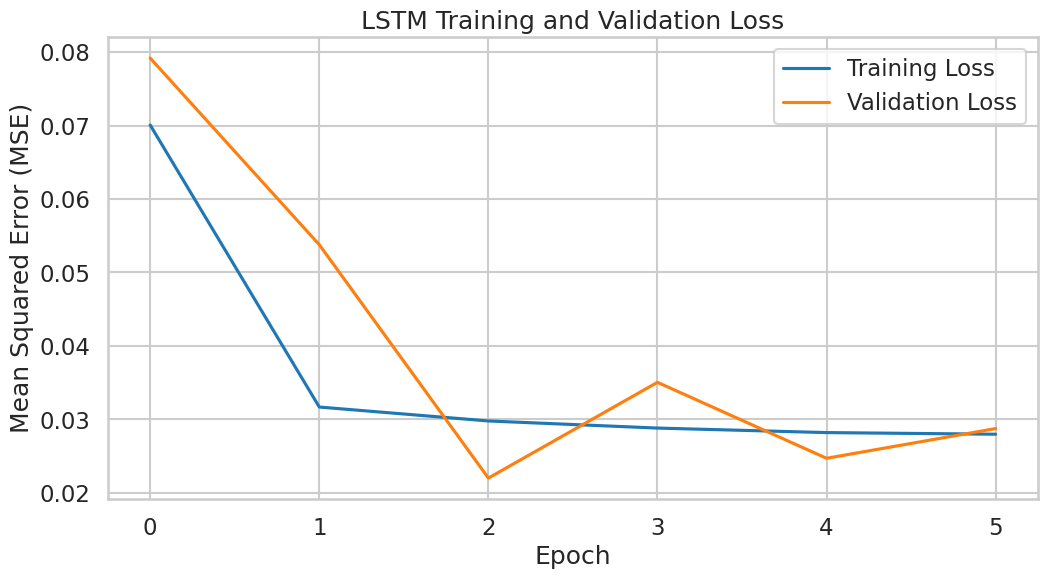

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True))
model.add(LSTM(75, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Dense output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Plot the training and validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
X_june, Y_june_true = create_sequences(june_data, seq_length)
X_june = np.array(X_june);
Y_june_true = np.array(Y_june_true);
model.compile(optimizer='adam', loss='mse');
X_june.shape,Y_june_true.shape

((10158, 15, 7), (10158,))

In [24]:

predictions = model.predict(X_june,batch_size=128)


80/80 [==============================] - 2s 15ms/step


In [25]:
def reverse_scaling(data, scaler):
    """
    Reverse the scaling effect on data.
    """
    # Convert data to a 2D array if it's 1D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    dummy = np.zeros((len(data), len(features_to_normalize)))
    
    # Set the last column of the dummy array to your data
    dummy[:, -1] = data.ravel()
    
    # Use inverse_transform to reverse the scaling
    unscaled = scaler.inverse_transform(dummy)
    
    # Return the last column (our actual unscaled data)
    return unscaled[:, -1]


In [26]:
# Reverse scaling for Y_june_true and predictions
Y_june_true_unscaled = reverse_scaling(Y_june_true, scaler)
predictions_unscaled = reverse_scaling(predictions, scaler)

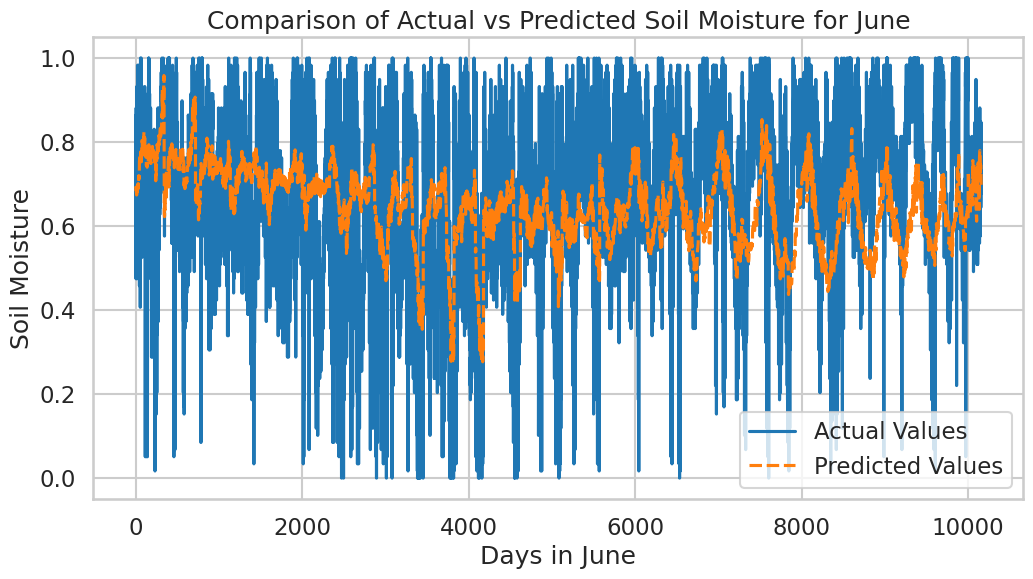

In [27]:
# Ensure both arrays are 1-dimensional
Y_june_true_unscaled = Y_june_true_unscaled.ravel()
predictions_unscaled = predictions_unscaled.ravel()

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual Values': Y_june_true_unscaled,
    'Predicted Values': predictions_unscaled
})

# Set Seaborn style
sns.set_style("whitegrid")

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot)
plt.title('Comparison of Actual vs Predicted Soil Moisture for June')
plt.ylabel('Soil Moisture')
plt.xlabel('Days in June')
plt.legend()
plt.show()

In [28]:
# Calculate MAE
mae = np.mean(np.abs(Y_june_true_unscaled - predictions_unscaled))
print(f"Mean Absolute Error for June Predictions: {mae}")

Mean Absolute Error for June Predictions: 0.15346669589212786


<a id="conclu"></a>
<h2 style="color: #e67e22; border-bottom: 2px solid #3498db; padding-bottom: 10px;">Conclusion: Taking Baby Steps with LSTM</h2>

<h4 style="color: #3498db;">What We Achieved:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>We built an LSTM model and got an error score of 0.06 to 0.07. This means our model is doing something right!</li>
    <li>Our model seems to "get" the bigger picture of soil moisture data trend, even if it misses some small details. There is definetly room to improve it by incorporating L1 or L2 regularization, playing with batch size or epochs etc.</li>
</ul>

<h4 style="color: #3498db;">What's Next?</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>But remember, our main goal was to show how LSTMs can work even when some data is missing. And we did that!</li>
</ul>

<h4 style="color: #3498db;">Final Thoughts:</h4>
<ul style="color: #34495e; font-size: 16px;">
    <li>This notebook is like a first step in a big journey of Nueral Networks. We learned, we tried, and we saw some cool stuff (I hope). There's more out there!</li>
</ul>

